In [127]:
import pandas as pd 
import os 
import numpy as np 
from src.download import *
from tqdm import tqdm  
from src.files.fasta import FASTAFile
import subprocess 
import glob
import src.tools as tools 
import matplotlib.pyplot as plt 
import seaborn as sns
from utils import *
import re

%load_ext autoreload 
%autoreload 2

# Currently, the only phylogenetic trees I have are based on aRF1 sequences. Although it seems as though this might track fairly closely with 16S-based
# phylogeny, this might be a bad approach, particularly if the hypothesis that there may be some conserved changes in the aRF1s associated
# with Pyl usage is correct. In this case, the tree may overestimate the distance between Pyl-utilizing organisms. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
# https://academic.oup.com/mbe/article/32/5/1242/1127015

# Petitjean et. al. seem to have used BLAST alignment to identify the proteins used to build the tree. 

# Proteins used for the extended conserved phylogenetic core for Archaea. 
petitjean_table_1_df = pd.read_csv('../data/phylogeny/petitjean_2015_table_1.csv')

In [111]:
protein_ids = petitjean_table_1_df.pid.unique()

if not os.path.exists('../data/phylogeny/conserved_core.csv'):
    core_df = [download_protein_info(protein_id, include_sequence=True) for protein_id in tqdm(protein_ids, 'Downloading conserved phylogenetic core proteins...')]
    core_df = pd.DataFrame(core_df).set_index('id')
    core_df.to_csv('../data/phylogeny/conserved_core.csv')
core_df = pd.read_csv('../data/phylogeny/conserved_core.csv', index_col=0)
FASTAFile().from_df(core_df).write('../data/phylogeny/conserved_core.fa')


In [112]:
# Petitjean et. al. define a protein family as proteins with >60% similarity. 

arf1_df = pd.read_csv('../data/arf1_cleaned.csv')
genome_ids = arf1_df.genome_id.values
methanosarcinales_genome_ids = arf1_df[arf1_df.order == 'Methanosarcinales'].genome_id.values

database_path = '../data/phylogeny/conserved_core'

for genome_id in tqdm(genome_ids, desc='Running BLAST against conserved phylogenetic core...'):
    query_path = f'../data/prodigal/{genome_id}.fa'
    output_path = f'../data/phylogeny/blast/{genome_id}_blast.tsv'
    if not os.path.exists(output_path):
        subprocess.run(f'blastp -query {query_path} -db {database_path} -outfmt 6 -max_hsps 10 -out {output_path} -num_threads 10', shell=True, check=True)

Running BLAST against conserved phylogenetic core...: 100%|██████████| 2489/2489 [00:00<00:00, 141861.97it/s]


In [113]:
# cols = 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore'.split()
cols = 'query_id subject_id percent_identity length mismatch gap_open query_alignment_start query_alignment_stop subject_alignment_start subject_alignment_stop e_value bit_score'.split()

def load_blast(data_dir='../data/phylogeny/blast/', min_bit_score=30):
    blast_df = list()
    for path in tqdm(glob.glob(os.path.join(data_dir, '*')), desc='load_blast'):
        genome_id = os.path.basename(path).replace('_blast.tsv', '')
        blast_df_ = pd.read_csv(path, header=None, names=cols, sep='\t')
        blast_df_ = blast_df_[blast_df_.bit_score > min_bit_score].copy()
        blast_df_['genome_id'] = genome_id 
        blast_df.append(blast_df_)
    blast_df = pd.concat(blast_df)
    return blast_df


def load_sequences(blast_df, fa_dir='../data/prodigal/'): # , protein_ids:list=[]):
    ''''''
    seqs = dict() # BLAST DataFrame should already be filtered for the relevant protein IDs. 
    for genome_id, df in tqdm(list(blast_df.groupby('genome_id')), desc='load_sequences'): 
        fa_path = os.path.join(fa_dir, f'{genome_id}.fa')
        fa_df = FASTAFile().from_fasta(fa_path).to_df()
        fa_df = fa_df[fa_df.index.isin(df.query_id.unique())].copy()
        seqs.update(fa_df.seq.to_dict())
    blast_df['seq'] = blast_df.query_id.map(seqs) # Add the subject sequences to the DataFrame. 
    return blast_df

In [132]:
if not os.path.exists('../data/phylogeny/blast.csv'):
    blast_df = load_blast()
    blast_df = load_sequences(blast_df)
    blast_df.to_csv('../data/phylogeny/blast.csv')

blast_df = pd.read_csv('../data/phylogeny/blast.csv', index_col=0)
blast_df['methanosarcinales'] = blast_df.genome_id.isin(methanosarcinales_genome_ids)
blast_df = blast_df[blast_df.bit_score > 40].copy()
# First, select the strongest hit for each query sequence. 
blast_df = blast_df.sort_values('bit_score', ascending=False).drop_duplicates('query_id', keep='first') # Remove any cases where the same pair has two alignments. 
blast_df = blast_df[blast_df.methanosarcinales].copy()
blast_df['subject_description'] = blast_df.subject_id.map(petitjean_table_1_df.set_index('pid').Annotation)

print('Num. genomes with BLAST hits:', blast_df.genome_id.nunique())
print('Num. Methanosarcinales genomes with BLAST hits:', blast_df[blast_df.methanosarcinales].genome_id.nunique())
# Going to look only at Methanosarcinales for now because I don't have time to make MSAs for all 2000+ genomes. 


Num. genomes with BLAST hits: 74
Num. Methanosarcinales genomes with BLAST hits: 74


In [133]:
# Which proteins have one hit per genome?
# genome_ids_with_core_protein = {protein_id:df.genome_id.unique() for protein_id, df in blast_df.groupby('subject_id')}
# genome_counts_with_core_protein = {protein_id:len(genome_ids) for protein_id, genome_ids in genome_ids_with_core_protein.items()}

genome_ids_with_core_protein = {protein_id:df.genome_id.unique() for protein_id, df in blast_df[blast_df.methanosarcinales].groupby('subject_id')}
genome_counts_with_core_protein = {protein_id:len(genome_ids) for protein_id, genome_ids in genome_ids_with_core_protein.items()}

# Which proteins are present at least once in all the Methanosarcinales genomes?
protein_ids = [protein_id for protein_id, genome_ids in genome_ids_with_core_protein.items() if (len(genome_ids) == 74)]
protein_ids.remove('YP_001582216.1') # peptide chain release factor 1, also has some outliers. 

print('Num. proteins present in all Methanosarcinales genomes:', len(protein_ids))
blast_df = blast_df[blast_df.subject_id.isin(protein_ids)].copy()

Num. proteins present in all Methanosarcinales genomes: 12


In [134]:
gtdb_metadata_df = pd.read_csv('../data/ar53_metadata_r226.tsv', sep='\t', index_col=0)
gtdb_metadata_df.index = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in gtdb_metadata_df.index]
gtdb_metadata_df = gtdb_metadata_df.loc[methanosarcinales_genome_ids].copy()
gtdb_metadata_df['species'] = [re.search(r's__(.+)', taxonomy).group(1) for taxonomy in gtdb_metadata_df.gtdb_taxonomy]

blast_df['species'] = blast_df.genome_id.map(gtdb_metadata_df.species)

In [135]:
for protein_id, df in blast_df.groupby('subject_id'):
    # There are several cases where there seem to be multiple copies of a core conserved sequence in the same genome. 
    # This could be a sequencing error or a genuine result, but seems like the best course of action is just select the one 
    # which most closely resembled the reference. 
    df = df.sort_values('e_value').drop_duplicates('genome_id')
    # assert df.genome_id.duplicated().sum() == 0, 'There shouldn\'t be multiple hits in the same genome.'
    df = df.set_index('species')
    FASTAFile().from_df(df).write(f'../data/phylogeny/msa/{protein_id}.fa')

for input_path in glob.glob('../data/phylogeny/msa/*'):
    muscle_output_path = input_path.replace('.fa', '.afa')
    trimal_output_path = input_path.replace('.fa', '_trimmed.afa')
    if os.path.exists(muscle_output_path):
        subprocess.run(f'~/muscle5.1.linux_intel64 -align {input_path} -output {muscle_output_path}', shell=True, check=True)
    subprocess.run(f'trimal -in {muscle_output_path} -out {trimal_output_path}', shell=True, check=True)


muscle 5.1.linux64 [12f0e2]  32.5Gb RAM, 16 cores
Built Jan 13 2022 23:17:13
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 74 seqs, avg length 769, max 1928

00:00 4.4Mb  CPU has 16 cores, running 16 threads
00:55 1.2Gb   100.0% Calc posteriors
00:57 1.2Gb   100.0% Consistency (1/2)
00:59 1.2Gb   100.0% Consistency (2/2)
00:59 1.2Gb   100.0% UPGMA5           
01:02 1.2Gb   100.0% Refining

muscle 5.1.linux64 [12f0e2]  32.5Gb RAM, 16 cores
Built Jan 13 2022 23:17:13
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 74 seqs, avg length 303, max 360

00:00 4.3Mb  CPU has 16 cores, running 16 threads
00:07 1.1Gb   100.0% Calc posteriors
00:07 1.1Gb   100.0% Consistency (1/2)
00:08 1.1Gb   100.0% Consistency (2/2)
00:08 1.1Gb   100.0% UPGMA5           
00:08 1.1Gb   100.0% Refining

muscle 5.1.linux64 [12f0e2]  32.5Gb RAM, 16 cores
Built Jan 13 2022 23:17:13
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 74 seqs, avg length 508, 

In [117]:
def concatenate_msas(data_dir:str='../data/phylogeny/msa', output_path:str='../data/phylogeny/core.afa', partition_path='../data/phylogeny/partition.txt'):
    paths = glob.glob(os.path.join(data_dir, '*_trimmed.afa')) # Make sure to use the trimmed alignments. 
    msa_df = FASTAFile().from_fasta(paths[0]).to_df()

    partition = list()
    i = 1
    for path in paths[1:]:

        df = FASTAFile().from_fasta(path).to_df()
        df = df.loc[msa_df.index] # Make sure indices are aligned. 
        msa_df['seq'] = msa_df.seq.str.cat(df.seq)

        protein_id = os.path.basename(path).replace('.afa', '') # Extract the protein ID from the file name. 
        length = df.seq.apply(len).iloc[0] # Get the length of the alignment. 
        partition.append(f'PROT, {protein_id} = {i}-{i + length}')

        i += (length + 1)
    
    FASTAFile().from_df(msa_df).write(output_path)
    with open(partition_path, 'w') as f:
        f.write('\n'.join(partition))

concatenate_msas()
run_muscle('../data/phylogeny/core.afa', build_tree=True)

FastTree Version 2.2.0 Double precision
Alignment: ../data/phylogeny/core.afa
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jones-Taylor-Thorton, CAT approximation with 20 rate categories
Ignored unknown character * (seen 933 times)
Ignored unknown character X (seen 118 times)
      0.10 seconds: Checking top hits for      1 of     74 seqs
Initial topology in 0.96 seconds
Refining topology: 25 rounds ME-NNIs, 2 rounds ME-SPRs, 12 rounds ML-NNIs
      0.95 seconds: ME NNI round 1 of 25, 1 of 72 splits
      1.15 seconds: ME NNI round 2 of 25, 1 of 72 splits
      1.37 seconds: ME NNI round 3 of 25, 1 of 72 splits
      1.49 seconds: ME NNI round 4 of 25, 1 of 72 splits
      1.61 seconds: SPR round   1 of   2, 1 of 146 nodes
      5.68 seconds: SPR round   1 of   2, 101 of 146 nodes
      7.38 seconds: ME NNI round 9 of 25, 1 of 72 splits
      

In [118]:
stop_codon_metadata_df = pd.read_csv('../data/arf1_stop_codon_metadata.csv', index_col=0)
stop_codon_metadata_df['tag_percent'] = stop_codon_metadata_df.TAG / stop_codon_metadata_df['total']
stop_codon_metadata_df['has_pyl'] = arf1_df.groupby('genome_id').has_pyl.first()
stop_codon_metadata_df = stop_codon_metadata_df.loc[methanosarcinales_genome_ids]

styles = {id_:'bold' for id_ in stop_codon_metadata_df[stop_codon_metadata_df.has_pyl].index}
sizes = {id_:2 for id_ in stop_codon_metadata_df[stop_codon_metadata_df.has_pyl].index}
tools.make_itol_annotation_file(stop_codon_metadata_df, field='tag_percent', path='../data/itol/core_methanosarcinales_tag_percent_annotation.txt', styles=styles, sizes=sizes)


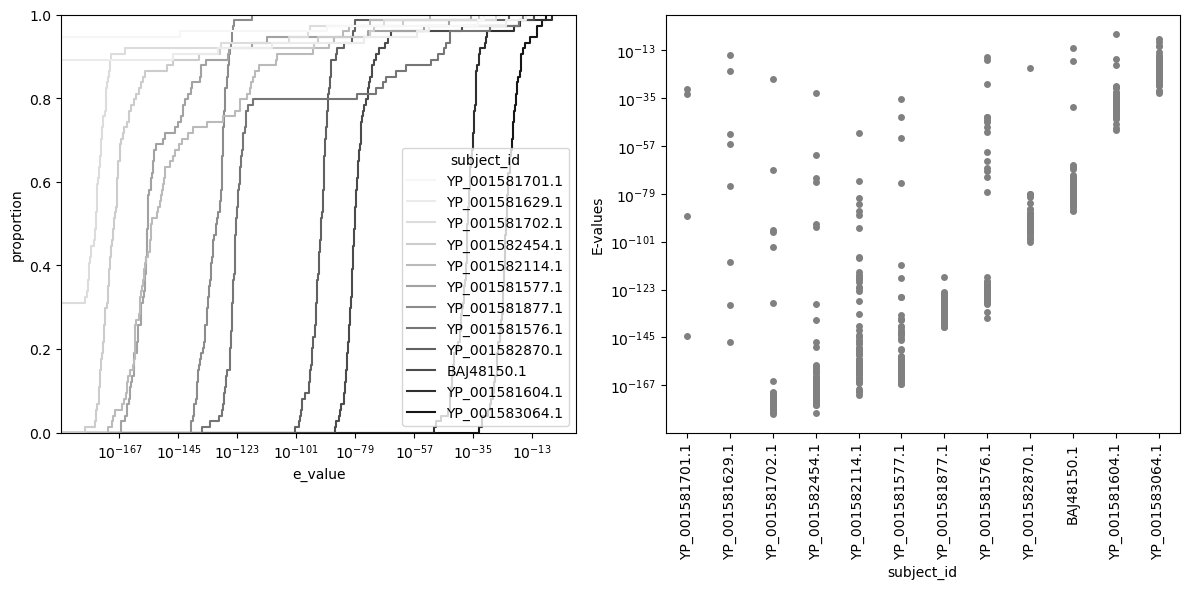

In [119]:
genome_id = 'GCF_018609725.1'
fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(12, 6))

figure_df = blast_df.copy()
figure_df = figure_df.sort_values('e_value').drop_duplicates(['genome_id', 'subject_id'])

ax_a_df = figure_df.copy()
sns.ecdfplot(ax_a_df, x='e_value', hue='subject_id', palette='Grays', ax=ax_a)
ax_a.set_xscale('log')
ax_a.set_ylabel('proportion')

ax_b_df = figure_df.copy()
# ax_b_df['min_e_value'] = figure_df.groupby('subject_id', as_index=False).e_value.max() - figure_df.groupby('subject_id', as_index=False).e_value.min()
sns.stripplot(ax_b_df, ax=ax_b, y='e_value', x='subject_id', color='Gray', jitter=False)
ax_b.set_ylabel('E-values')
ax_b.set_xticks(ax_b.get_xticks(), labels=ax_b.get_xticklabels(), rotation=90)
ax_b.set_yscale('log')

fig.tight_layout()
plt.show()

In [ ]:

print(list(gtdb_metadata_df.columns))

['ambiguous_bases', 'checkm2_completeness', 'checkm2_contamination', 'checkm2_model', 'checkm_completeness', 'checkm_contamination', 'checkm_marker_count', 'checkm_marker_lineage', 'checkm_marker_set_count', 'checkm_strain_heterogeneity', 'coding_bases', 'coding_density', 'contig_count', 'gc_count', 'gc_percentage', 'genome_size', 'gtdb_genome_representative', 'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation_ncbi_taxa', 'gtdb_type_designation_ncbi_taxa_sources', 'gtdb_type_species_of_genus', 'l50_contigs', 'l50_scaffolds', 'longest_contig', 'longest_scaffold', 'lsu_23s_contig_len', 'lsu_23s_count', 'lsu_23s_length', 'lsu_23s_query_id', 'lsu_5s_contig_len', 'lsu_5s_count', 'lsu_5s_length', 'lsu_5s_query_id', 'lsu_silva_23s_blast_align_len', 'lsu_silva_23s_blast_bitscore', 'lsu_silva_23s_blast_evalue', 'lsu_silva_23s_blast_perc_identity', 'lsu_silva_23s_blast_subject_id', 'lsu_silva_23s_taxonomy', 'mean_contig_length', 'mean_scaffold_length', 'mimag_high_quality', 'mimag_lo

In [131]:
gtdb_metadata_df.species.tolist()

['Methanosarcina sp035390745',
 'MTP4 sp9310u',
 'Methanosarcina sp030054735',
 'Methanosarcina sp002508465',
 'MTP4 sp016841625',
 'Methanosarcina sp11020u',
 'Methanosarcina sp023399215',
 'Methanosarcina sp002509325',
 'Methanogaster_C sp021159385',
 'Methanococcoides sp021108275',
 'Methanococcoides sp021108185',
 'MTP4 sp016841265',
 'Methanosarcina sp001714685',
 'Methanosarcina sp002499445',
 'Methanosarcina sp003164755',
 'Methanogaster_B sp034659235',
 'Methanohalobium sp018609725',
 'Methanococcoides sp038432375',
 'Methanogaster_C sp002506015',
 'Methanogaster_C sp034658695',
 'JAFGQV01 sp016935475',
 'DQIP01 sp020793555',
 'JAQVBP01 sp028690255',
 'DQIP01 sp019429165',
 'DQIP01 sp030611265',
 'Methanogaster_A sp034717055',
 'Methanogaster_A sp002503595',
 'Methanogaster_A sp030604085',
 'Methanogaster_A sp034659035',
 'Methanogaster_A sp013572355',
 'Methanococcoides sp963676195',
 'DQIP01 sp023544565',
 'Methanogaster_A sp030625165',
 'Methanolobus sp016932675',
 'DQIP01 s